# Overview
The purpose of this notebook is to train linear classifier layer (detectors) using a human in the loop approach.
It is assumed that embeddings from the desired model have already been generated using the other notebook "create_embeddings.ipynb".

This notebook is divided is 
Load packages
Define paths
Load embedding model


In [1]:
# Import various dependencies, including the relevant modules from the Perch
# repository. Note that "chirp" is the old name that the Perch team used, so any
# chirp modules imported here were installed as part of the Perch repository in
# one of the previous cells.

import collections
from collections import Counter
from etils import epath
import ipywidgets as widgets
from IPython.display import display as ipy_display
import matplotlib.pyplot as plt
from ml_collections import config_dict
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
import tqdm
import os
import json

from chirp import audio_utils
from chirp.inference import embed_lib
from chirp.inference import tf_examples
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib

2025-02-11 10:43:09.323356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 10:43:09.335347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739266989.349952    6437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739266989.354702    6437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 10:43:09.369996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Check GPU is used, return [] if 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model and dataset selection
- Choose the embeddings model model
- Make sure the folder architecture respect the one in the README.md

### Specify the data (inputs) and results (outputs) folders
To execute this pipeline, we need paths to folders, no modifications are needed if the architecture was respected:
- `unlabeled_audio_pattern`: files where the unlabeled audio dataset is stored.
- `embedding_output_dir`: the directory where the embedded audio will be written.
- `labeled_data_path`: the directory where the labeled samples will be placed post-search and active learning loop.

In [3]:
from utils_agile_model import choose_embedding_model

# Choose embeddings model (birdnet/surfperch/perch)
model_name = "surfperch"
embed_fn, config = choose_embedding_model(model_name)

# For readability later in the code
sample_rate = config.embed_fn_config.model_config.sample_rate
hop_size_s = config.embed_fn_config.model_config.hop_size_s
window_size_s = config.embed_fn_config.model_config.window_size_s

print(f"Ready to use Agile Modeling with '{model_name}' model")
print(f"Sampling rate:{sample_rate}Hz, Window size:{window_size_s}sec, Hop size:{hop_size_s}sec")

# Path to dataset
sample_data_folder = "./Shimoni pilot Data/"
output_directory = "./Shimoni pilot Outputs/"

# Enter the name of the folder containing the dataset bellow
dataset_folder = '(NT-R-2)'

# Specify a glob pattern matching any number of wave files.
# Use [wW][aA][vV] to match .wav or .WAV files
unlabeled_audio_pattern = os.path.join(sample_data_folder, dataset_folder, 'raw_audio/*.[wW][aA][vV]')

print("Working on dataset: ", dataset_folder)
print("Input data folder: ", sample_data_folder)
print("Output data folder: ", output_directory)



Loading surfperch...


I0000 00:00:1739266998.208988    6437 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 617 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:15:00.0, compute capability: 7.5


Test-run of model...


I0000 00:00:1739267001.246970    6437 service.cc:148] XLA service 0x2754fb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739267001.247000    6437 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-11 10:43:21.503936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1739267001.517429    6437 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1739267001.968771    6437 cuda_dnn.cc:529] Loaded cuDNN version 90701
E0000 00:00:1739267002.795403    6437 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1739267002.913641    6437 gpu_timer.cc:82] Delay kernel timed out: measured time has s


Setup complete!
Ready to use Agile Modeling with 'surfperch' model
Sampling rate:32000Hz, Window size:5.0sec, Hop size:5.0sec
Working on dataset:  (NT-R-2)
Input data folder:  ./Shimoni pilot Data/
Output data folder:  ./Shimoni pilot Outputs/


I0000 00:00:1739267006.950678    6437 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<a name=embed_data></a>
## Retrieve Embeddings ⏳

The **embeddings** for the chosen deployment and model should have been generated beforehand, if not the case, follow the instructions in the create_embeddings.ipynb file.

Recall that the embeddings are new representations of the original data that are generated by the pretrained model. It is important to remember that we are **not** using our pretrained model to classify the new reef dataset.  Rather, we're using the model's **learned features** to map our data into a new representation that is more amenable to simpler classification techniques. The pretrained model was very computationally costly to train. So, the idea is that the heavy lifting of learning salient features has already been done during development of the pretrained model. We can use this pretrained model to extract these features from new marine bioacoustic data, then train a much lighter-weight machine learning model on top of these features. This is the concept of **transfer learning**, ie, re-using the features learned by a model, but in a novel setting.


In [6]:
# Folder with the embeddings
embedding_output_dir = os.path.join(output_directory, dataset_folder, model_name, 'raw_embeddings')
config.output_dir = embedding_output_dir
config.source_file_patterns = [unlabeled_audio_pattern]

# # Create output directory and write the configuration.
# output_dir = epath.Path(config.output_dir)
# output_dir.mkdir(exist_ok=True, parents=True)

# Check that embeddings exist and are in the output directory
if os.path.isfile(os.path.join(config.output_dir,'config.json')):
    print("Config file found. Loading embeddings metadata.")
    # Get parameters from json config files
    # Open and read the JSON file
    with open(os.path.join(config.output_dir,'config.json'), 'r') as file:
        embedding_config = json.load(file)
    config.shard_len_s = embedding_config['shard_len_s']
    config.num_shards_per_file = embedding_config['num_shards_per_file']
    config.tf_record_shards = embedding_config['tf_record_shards']

    if len(os.listdir(embedding_output_dir)) == (config.tf_record_shards + 1):
        print("Embeddings found.")
    else:
        print("Number of embeddings files does not match config. It should not be possible.")
        
else:
    print("Config and embedding files not found. Go to create_embeddings.ipynb or verify paths")

Config file found. Loading embeddings metadata.
Embeddings found.


### Write the configuration to JSON to ensure consistency with later stages of the pipeline

In [7]:
# Create SourceInfos configuration, used in sharded computation when computing embeddings. These source_infos contain metadata about how we're going to
# partition the search corpus. In particular, the audios are splitted into hundreds of 5s chunks. The source_infos help us keep track of
# which chunk came from which raw audio file.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    config.num_shards_per_file,
    config.shard_len_s)
print(f'Constructed {len(source_infos)} source infos.')     #Should match the number of wav files in raw audio folder

Constructed 30 source infos.


<a name=similarity-search></a>
## Audio Similarity Search 🔎

We are set to start exploring the search corpus to train the model. In this section we will find examples that are similar to our query, and we'll manually label each sample as our target query or 'Unknown'.  These labeled samples then get saved and will be used as training data for the linear classifier in the next section.

Recall that an *embedding* is simply a vector (point) in some high dimensional space.  The similarity search we implement relies on comparison two vectors. Vectors can be compared with euclidean distance, cosine similarity or Maximum Inner Product (MIP).

**Note:** In practice, we may end up looping through this section repeatedly with different query samples (if we have them) and different search parameters to find enough true positive matches and negatives. There is no hard rule, but aim for at least 10 negatives and 5 positive matches.


### Define the target classes

We specify the classes (aka labels) that we want to search for within the search corpus. In our case, we're primariy interested in finding instances of our target query, so this will be one of our two classes alongside an "Unknown" class, where "Unknown" will be used for anything that is not the target sample

The Active Learning technique is *extremely* flexible and can be adapted to a wide variety of use cases.

### Target sounds

Selection of target sounds provided in your dataset folder

Number of different target sounds:  5
Target sound label:  C


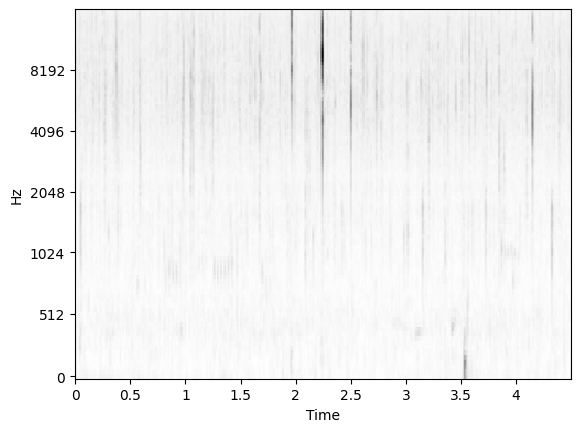

Target sound label:  A


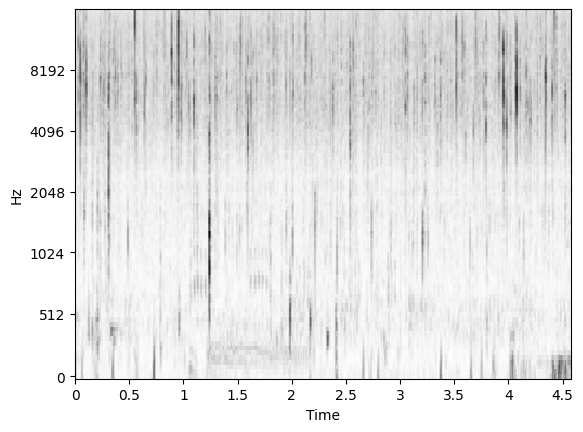

Target sound label:  B


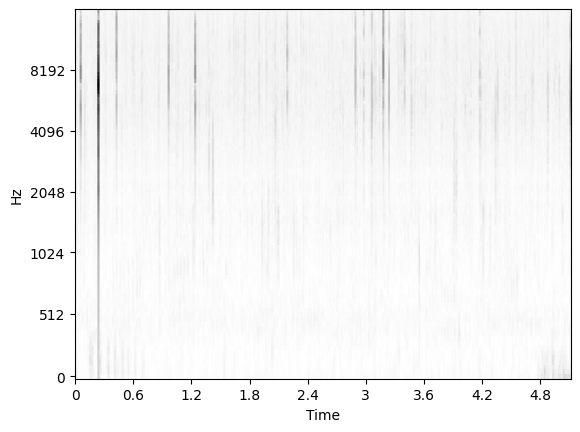

Target sound label:  E


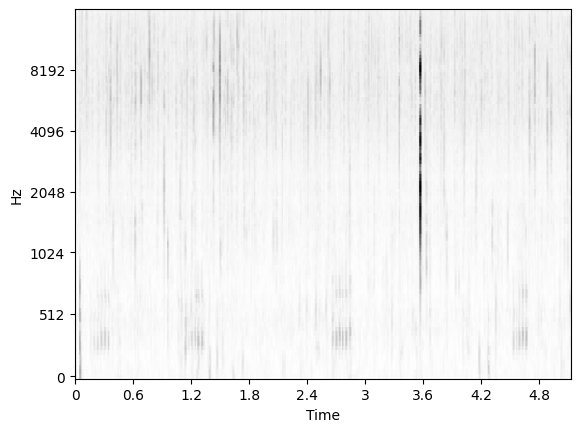

Target sound label:  D


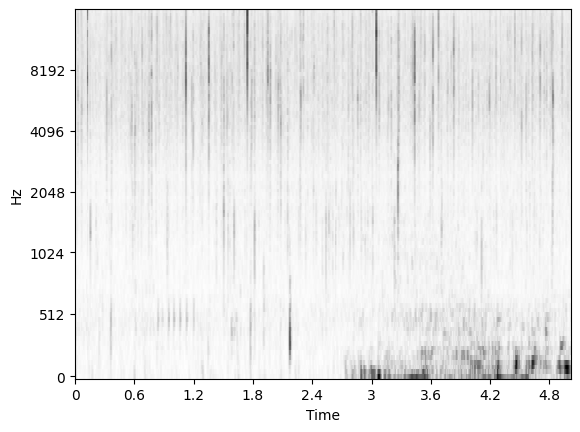

In [9]:
#@title { vertical-output: true }
# Path to ref target sound folders
target_sounds = os.path.join(sample_data_folder, dataset_folder, 'ref_sound')
target_sounds_folders = os.listdir(target_sounds)

# For each target sound folder, find the first audio file as an example
example_target_sounds = []
for folder in target_sounds_folders:
  wav_files = [file for file in os.listdir(os.path.join(target_sounds, folder)) if file.lower().endswith('.wav')]
  example_sound_path = os.path.join(target_sounds, folder + '/' + wav_files[0])
  example_target_sounds.append(example_sound_path)

# Now view each example target sound
print('Number of different target sounds: ', len(example_target_sounds))
for audio_path in example_target_sounds:
  print('Target sound label: ', audio_path.split('/')[-2])
  audio = audio_utils.load_audio(audio_path, sample_rate)
  display.plot_audio_melspec(audio, sample_rate)

In [10]:
# @title Hit run on this cell and pick a target sound

# Ensure the path exists and list directories
if os.path.exists(target_sounds):
    sound_folders = [f for f in os.listdir(target_sounds) if os.path.isdir(os.path.join(target_sounds, f))]
else:
    print("Path does not exist:", target_sounds)
    sound_folders = []

# Create and display the dropdown
sound_dropdown = widgets.Dropdown(
    options=sound_folders,
    description='Select sound:',
    disabled=False,
)

# Define a function that reacts to changes in the dropdown
def on_sound_change(change):
    choice = change['new']
    print(f'Changed target sound to: {choice}. Now work through the cells below for this dataset.')

# Attach the observer to the dropdown
sound_dropdown.observe(on_sound_change, names='value')

ipy_display(sound_dropdown)

Dropdown(description='Select sound:', options=('C', 'A', 'B', 'E', 'D'), value='C')

### Prepare the query vector

We're now ready to create the 'query', which uses our selected target sound.  In general, this query is the audio that you're looking for in your search corpus.

Number of indexed audio files in target sound directory: 1
Viewing example: 1
Selected audio window:


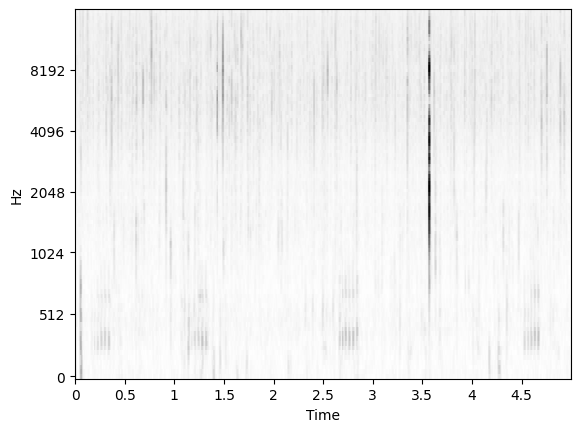

In [11]:
#@title Load and view the query audio sample { vertical-output: true }
target_sound = sound_dropdown.value
target_classes = [target_sound, 'Unknown']

# Select one of the target audio files. Default with 1, but when many sounds are available,
# the user can choose which one to use for the similarity search.
file_index = 1  #@param
file_index = file_index -1

# Build the folder path
target_audio_folder = os.path.join(sample_data_folder, dataset_folder, 'ref_sound', target_sound)

# Retrieve all .wav files
wav_files = [file for file in os.listdir(target_audio_folder) if file.lower().endswith('.wav')]

# Print the total number of audio files
print(f"Number of indexed audio files in target sound directory: {len(wav_files)}")

# Validate the user input and select the audio file
if 0 <= file_index < len(wav_files):
    audio_path = os.path.join(target_audio_folder, wav_files[file_index])
    print(f"Viewing example: {file_index + 1}")
else:
    print("Invalid file index. Please select a valid index up to and including: ", len(wav_files))
    audio_path = None

# Assuming the rest of the code executes only if a valid path is selected
if audio_path:
    audio = audio_utils.load_audio(audio_path, sample_rate)
    # display.plot_audio_melspec(audio, sample_rate)


#@title { vertical-output: true }
# If you're audio clip is longer than 5s, adjust start_s to pick your
# prefered start time.
start_s = 0  #@param

# Display the selected window.
print('Selected audio window:')
st = int(start_s * sample_rate)
end = int(st + window_size_s * sample_rate)
if end > audio.shape[0]:
  end = audio.shape[0]
  st = max([0, int(end - window_size_s * sample_rate)])
audio_window = audio[st:end]
display.plot_audio_melspec(audio_window, sample_rate)

query_audio = audio_window
sep_outputs = None


#### Copy target samples to our labeled data directoy
It is possible to provide several target sounds, which will provide already labelled example for the model. Here, we will move the provided reference sounds to the `labeled_data_path`, which is the folder where the additional samples we find during the search phase later will be added.

The search phase may well find some of the same samples. The code will make sure not to save duplicate copies.

In [12]:
# The path to an empty directory where the generated labeled samples will be
# placed. Each labeled sample will be placed into a subdirectory corresponding
# to the target class that we select for that sample.
target_audio_outputs = os.path.join(output_directory, dataset_folder, model_name,'labeled_outputs', target_sound)
os.makedirs(target_audio_outputs, exist_ok=True)

# Copy all .wav and .WAV files from target_audio_folder to labeled_data_path
for file in os.listdir(target_audio_folder):
    if file.lower().endswith('.wav'):
        source_path = os.path.join(target_audio_folder, file)
        destination_path = os.path.join(target_audio_outputs, file)
        shutil.copy2(source_path, destination_path)

# Embed the query audio
embedded_query = embed_fn.embedding_model.embed(query_audio).embeddings[ :, 0, :]

### Create a TensorFlow Dataset (TFDS) wrapper over the embeddings
This is a technical step that wraps our search corpus in a TFDS object to allow us to use some convenient built-in features.

In [13]:
# Use the embedded dataset that we created above...
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embedding_output_dir,
      annotated_path=target_audio_outputs)

project_state = bootstrap.BootstrapState(
    bootstrap_config, embedding_model=embed_fn.embedding_model)

embeddings_ds = project_state.create_embeddings_dataset()

### <a name=top-k-search></a>Run top-k search using a comparison metric

#### Active learning step: 1

In this cell we run a "nearest neighbor" search over the search corpus to find embeddings that are closest to the query embedding according to our chosen metric.  These will correspond to snippets of our chosen dataset that sound similar to our query.

The `target_score` variable is a parameter that allows us to surface not just the closest matches, but rather matches that lie some fixed distance away.  When `target_score` is set to `None` (or `0`), the search will return the closest matches.

Recall that our goal in this section is to generate training data for a linear classifier. In order to train a robust model, we want this training dataset to contain both obvious/easy examples as well as not-so-obvious examples. If in our search we just looked for the closest possible matches, we would likely only find easy examples. The `target_score` param allows us to look for examples that might be less obvious (because they are farther away in embedding space).

Additionally, do not underestimate the usefulness of labeling 'Unknown' negative samples. Labeling a broad representation of negative samples present in the full dataset, especially those that currently score as close matches in the search, is key for training a classifier robust to false positives.

In [19]:
# Number of search results to capture. top_k = 25 is often a good start
top_k = 20 # @param {type:"number"}

# The Perch codebase supports:
#  'euclidean', which is the standard euclidean distance
#  'cosine', which is the cosine similarity,
#  'mip', which is Maximum Inner Product
metric = 'mip'  #@param['euclidean', 'mip', 'cosine']

# Target distance for search results. This lets us try to hone in on a
# 'classifier boundary' instead of just looking at the closest matches.
# Set to 'None' for raw 'best results' search.
target_score = 6 #@param
results, all_scores = search.search_embeddings_parallel(
    embeddings_ds, embedded_query,
    hop_size_s=hop_size_s,
    top_k=top_k, target_score=target_score, score_fn=metric,
    random_sample=False)

19it [00:00, 189.78it/s]2025-02-11 10:56:32.230375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
30it [00:00, 277.89it/s]


### Choose a target score by plotting a histogram of all distances in the search corpus

During the top-k search step above, the Perch code also computed and saved the distances to *every* point in the search corpus. The actual numerical values of these distances are hard to interpret, but the relative values are very useful. In the following cell we plot a histogram of this set of distances to help us conceptualize the geometry of our embedded dataset. This histogram helps us find and tune our values for the `target_score` variable in the top-k search.

A typical histogram will appear to fit some vaguely-normal looking distribution, possibly skewed left with a heavy tail. While there is no prescriptive formula for finding useful values of `target_score`, the Perch team has found that good choices tend to lie near the left-hand 'hockey-stick' point of the distribution.

These tend to correspond to examples that are faint, or have background noise, or are otherwise not especially obvious. Annotating these examples and adding them to the training set is very important because they help the linear model discriminate better on these less-clear "boundary" points. Though take care to make sure your annotations are correct, if in doubt you can leave samples unlabeled.



score < target_score percentage : 0.981


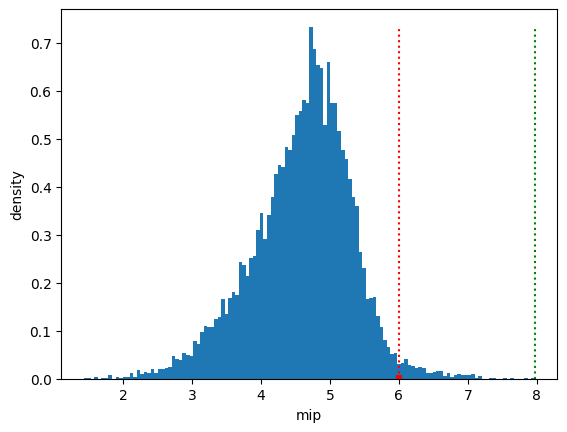

In [20]:
#@title { vertical-output: true }
# Plot histogram of distances.
ys, _, _ = plt.hist(all_scores, bins=128, density=True)
hit_scores = [r.score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)

plt.xlabel(metric)
plt.ylabel('density')
if target_score is not None:
  plt.plot([target_score, target_score], [0.0, np.max(ys)], 'r:')
  # Compute the proportion of scores < target_score.
  hit_percentage = (all_scores < target_score).mean()
  print(f'score < target_score percentage : {hit_percentage:5.3f}')
min_score = np.min(all_scores)
if metric == 'mip':
  plt.plot([np.max(all_scores), np.max(all_scores)], [0.0, np.max(ys)], 'g:')
else:
  plt.plot([min_score, min_score], [0.0, np.max(ys)], 'g:')

plt.show()

### User-in-the-loop data labeling (**requires user interaction**)

The cell below displays the search results in a user-interface in the following format:
* Image: a plot visualization of the audio search result (Mel spectrogram, frequency in Hz over time)
* A playback of the audio sample itself
* Metrics and metadata: `rank` position, `source file` of the recording segment, `offset_s` (in seconds) from the recording, and the search `score` (i.e. similarity with the query)
* Candidate labels for the sample

**Instructions to the user:** <br>
For each search result presented below, select either the target label or Unknown class. Samples which present difficult cases can be highly valuable to label, but if any cannot be labeled with confidence then its possible to leave them blank.

**Quick guide on how to verify vocalisations:**
One of the hardest parts of the entire process can be learning to correctly identify the target sounds for yourself. Often this requires a skilled bioacoustician to do well. Many common reef sounds can blur from one clear signal into another, especially tricky pulse, purr and pop vocalizations. When in doubt, take the time to check back against your original target sound. Make use of listening with a good set of earphones or headphones and also visually assessing the spectrogram.

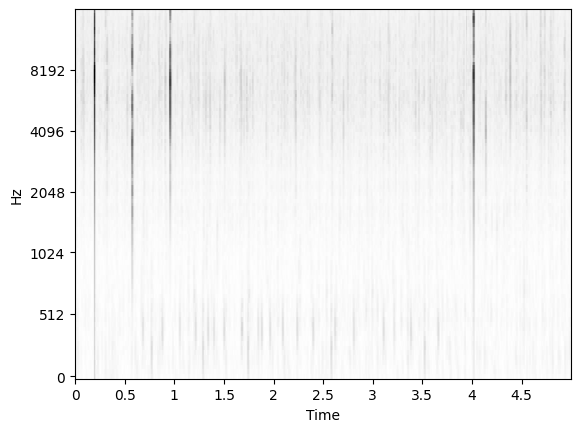

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

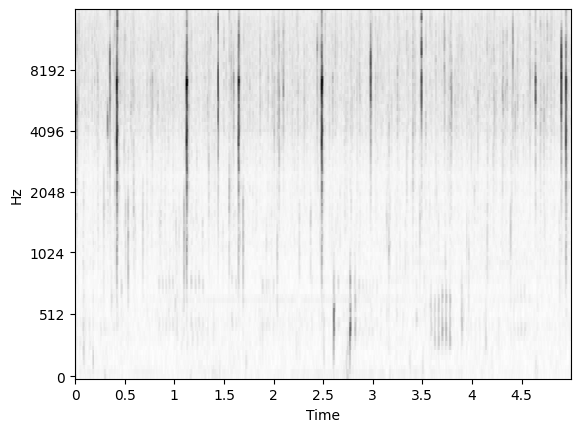

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

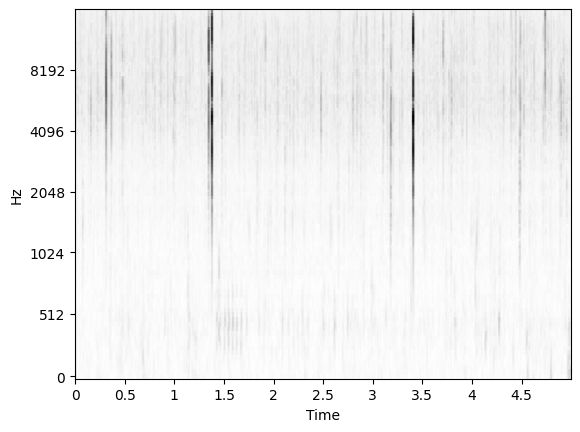

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

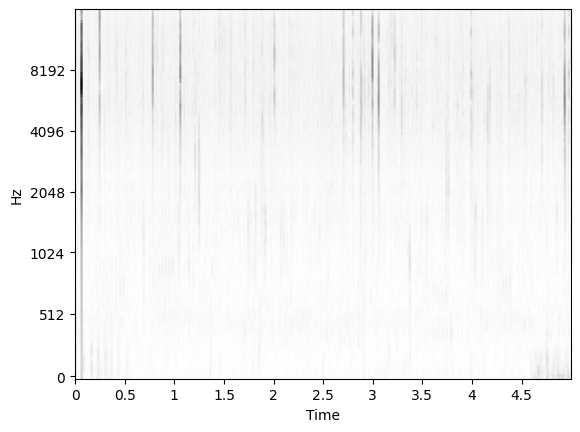

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

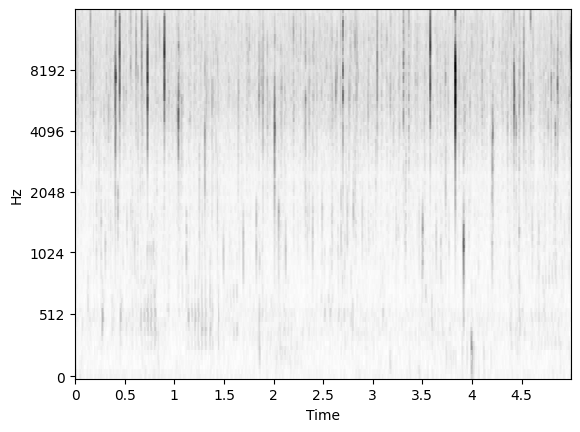

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

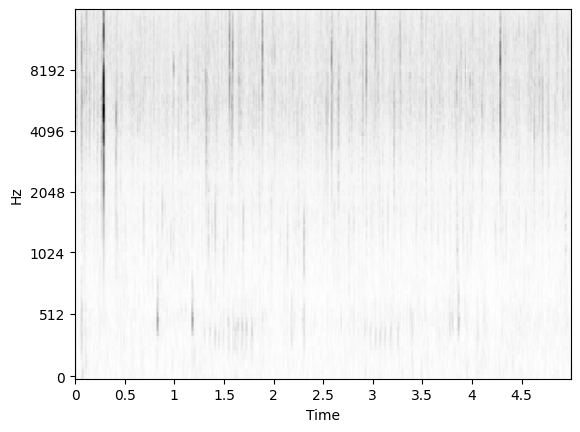

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

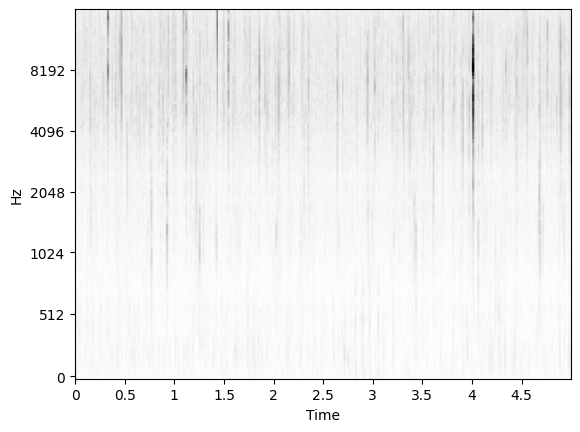

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

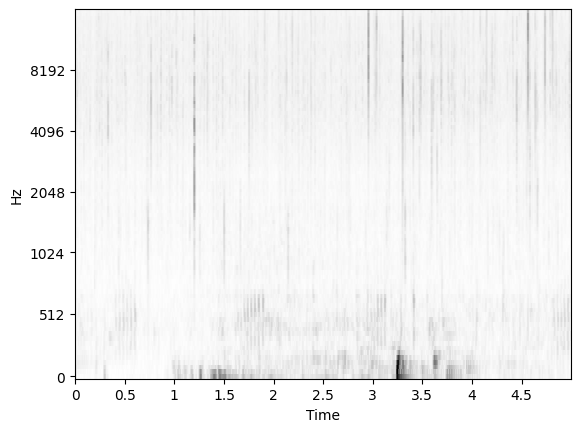

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

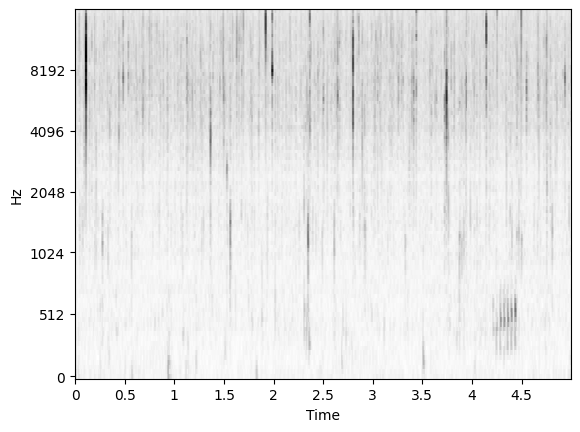

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

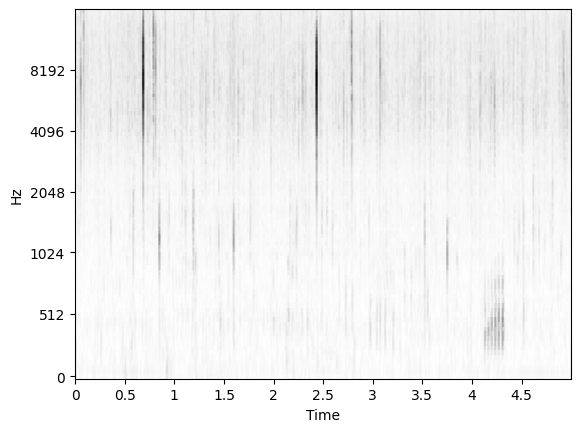

Button(description='E', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [ ]:
#@title Display the search results for user labeling. { vertical-output: true }
samples_per_page = 10
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=target_classes,
    max_workers=5,
)
  

# Let this cell finish executing before labeling the samples

### Write the user-annotated search results to file

This cell saves the annotations you generated in the previous step to your output folder.  It writes data to the `labeled_data_path` location that was specified above.

In [22]:
def write_labeled_data(search_results, labeled_data_path: str, sample_rate: int):
  """Write labeled results to the labeled data collection."""
  labeled_data_path = epath.Path(labeled_data_path)
  counts = collections.defaultdict(int)
  duplicates = collections.defaultdict(int)
  for r in search_results:
    labels = [ch.description for ch in r.label_widgets if ch.value]
    if not labels:
      continue
    extension = epath.Path(r.filename).suffix
    filename = epath.Path(r.filename).name[: -len(extension)]
    output_filename = f'{filename}___{r.timestamp_offset}{extension}'
    for label in labels:
      output_path = labeled_data_path / label
      output_path.mkdir(parents=True, exist_ok=True)
      output_filepath = epath.Path(output_path / output_filename)
      if output_filepath.exists():
        duplicates[f'{label}'] += 1
        continue
      else:
        counts[label] += 1
      with output_filepath.open('wb') as f:
        wavfile.write(f, sample_rate, np.float32(r.audio))
  for label, count in counts.items():
    print(f'Wrote {count} examples for label {label}')
  for label, count in duplicates.items():
    print(f'Not saving {count} duplicates for label {label}')

labeled_data_path = os.path.join(output_directory, dataset_folder, model_name, 'labeled_outputs/')
write_labeled_data(results, labeled_data_path, sample_rate)

Wrote 7 examples for label Unknown
Wrote 13 examples for label E


## Train a Linear Classifier with active learning 🤖🧠

In the active learning step above, we labeled samples from the search dataset as matches (by similarity comparison with the queries) for our target classes. If you're satisfied you labelled enough samples, you likely want to focus your efforts using the step below.

We will now train a simple linear model using those bootstrapped (labeled) data points from the search dataset.

**Important:** in order to be able to train the linear model, we need several examples from each of the two classes (more is better!). If you encounter an error in this section when training the model, you likely did not generate a sufficient amount of labeled data. Please go back to the previous section and choose a new value of the `target_score` attribute and label some more data.

In [23]:
#@title Display results for the target label { vertical-output: true }

# Load the training data that is located in the `labeled_data_path` directory.
# In that directory there will be folders corresponding to our target labels

merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=labeled_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling='mean',
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
lbl_counts = np.sum(merged.data['label_hot'], axis=0)
print('num classes :', (lbl_counts > 0).sum())
print('mean ex / class :', lbl_counts.sum() / (lbl_counts > 0).sum())
print('min ex / class :', (lbl_counts + (lbl_counts == 0) * 1e6).min())

Embedding from Folder of Folders...
Checking for existing embeddings from Folder of Folders...
Found 0 existing embeddings.
Checking for new sources to embed from Folder of Folders...


34it [00:00, 115.89it/s]
7it [00:00, 97.36it/s]



...embedded dataset in  0.38s...
    found 2 classes.
    class E / 0 : 34
    class Unknown / 1 : 7
num classes : 2
mean ex / class : 20.5
min ex / class : 7.0


### Train a simple linear model using the labeled embeddings

We use the following hyperparameters which should serve as reasonably performing defaults to train this linear model (classifier):

- `batch_size`: 12
- `num_epochs`: 128
- `num_hiddens`: -1 (to match the dimensions of the embeddings)
- `learning_rate`: 0.001

Additionally, we compute the following metrics to measure the "goodness" of the trained model:
- `acc`: overall accuracy
- `auc_roc`: AUC ROC, or area under the receiving curve
- `cmAP`: mean average precision averaged across species
- `maps`: mean average precision for each class

In [24]:
# Number of random training examples to choose from each class.

# Note that if you don't have very many samples you'll need to set
# train_ratio=None and train_examples_per_class to a value that is
# less than the minimum number of examples you have of each class.

# Set exactly one of train_ratio and train_examples_per_class
train_ratio = 0.8  #@param
train_examples_per_class = None  #@param

# Number of random re-trainings. In other words, this value indicates how many
# models we will train, each will use a new randomly selected combination of
# our labeled samples for training and testing. By training multiple models,
# we get a sense of model robustness. Here, we train 3, but feel free to
# increase it for added confidence in the model's performance.
num_seeds = 3  #@param

# Classifier training hyperparams.
# These should be good defaults.
batch_size = 12
num_epochs = 128
num_hiddens = -1
learning_rate = 1e-3

### Model training
Train linear classifier model. For more accurate indication of the performance, several model can be trained (num_seeds) which will use different training and validation sets. 

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Duplicate of cell bellow to compute different metrics
metrics_list = collections.defaultdict(list)
for seed in tqdm.tqdm(range(num_seeds)):
  if num_hiddens > 0:
    model = classify.get_two_layer_model(
        num_hiddens, merged.embedding_dim, merged.num_classes, batch_norm=True)
  else:
    model = classify.get_linear_model(
        merged.embedding_dim, merged.num_classes)
    
  run_metrics = classify.train_embedding_model(
      model, merged, train_ratio, train_examples_per_class,
      num_epochs, seed, batch_size, learning_rate)
  
  # Add metrics to metric list
  

100%|██████████| 3/3 [00:31<00:00, 10.59s/it]


#### Compute the average metrics and print the model performance

In the previous cells, the `num_seeds` param controls how many times we train a model.  Each time we train a model there is some randomness in terms of which data points we choose from our labeled data, as well as some randomness in the model's initialization.  We can get a sense of how robust our classifier is by training multple times and looking at the summary statistics computed by the following cell.  A low `auc_roc` value (ie, less than 0.9 or so) probably indicates that we should generate some more training data.

**Note**: If you are new to labeling marine sounds, it can also be tricky to be sure you've labeled everything correctly.

In [27]:
print(metrics_list)

defaultdict(<class 'list'>, {'precision': [], 'recall': [], 'f1': [], 'auc_roc': []})


In [26]:
mean_prec = np.mean(metrics_list['precision'])
mean_recall = np.mean(metrics_list['recall'])
mean_f1 = np.mean(metrics_list['f1'])

if not np.isnan(np.sum(metrics_list['auc_roc'])):
  mean_auc_roc = np.mean(metrics_list['auc_roc'])
else:
  print("Not enough samples in validation to compute auc-roc")
  mean_auc_roc = 0

print(f'macro precision:{mean_prec:5.2f}, macro recall:{mean_recall:5.2f}, macro f1:{mean_f1:5.2f}, auc_roc:{mean_auc_roc:5.2f}')

macro precision:  nan, macro recall:  nan, macro f1:  nan, auc_roc:  nan


### Generate new samples using logit scores


In [ ]:
# Choose the target class to work with.  This must be one of the values from
# the target_classes list above (target_sound or 'Unknown')

target_class = target_sound #@param

# Choose a target logit. You can start by setting this to 'None' to get the
# highest-logit examples, which should reveal more of the target sound.
# Next, selecting 0.0 should reveal samples the model
# currently finds difficult - these are very valuable to label.
target_logit = 2 #@param

# Number of results to display.
num_results = 10  #@param

# Create the embeddings dataset.
target_class_idx = merged.labels.index(target_class)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=hop_size_s,
    target_score=target_logit,
    top_k=num_results
)

#@title { vertical-output: true }
# Plot the histogram of model logits.
_, ys, _ = plt.hist(all_logits, bins=128, density=True)
plt.xlabel(f'{target_class} logit')
plt.ylabel('density')
plt.plot([target_logit, target_logit], [0.0, 0.5], 'r:')
plt.show()

In [ ]:
#@title Display results for the target label { vertical-output: true }

display_labels = merged.labels

extra_labels = []  #@param
for label in extra_labels:
  if label not in merged.labels:
    display_labels += (label,)
if 'Unknown' not in merged.labels:
  display_labels += ('Unknown',)

samples_per_page = 25
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=display_labels,
    max_workers=5,
)

#### Add selected results to the labeled data

As before, once we've annotated the examples from the previous cell, we'll save them in the `labeled_data_dir`.

In [ ]:
results.write_labeled_data(labeled_data_path, sample_rate)

Repeat the iterative process: now return to the 'Model training' cell and work down from here cell by cell once again, until you are satisified with the auc_roc score output by the 'Compute the average metrics' cell.

### When to stop?
If you have completed the active learning loop below a few times, and have a high auc_roc score (>0.95 or close to it), then move on to the 'Inference stage' cell below.

Warning, performance measured on small amount of samples are not reliable (the more the better)
It is possible that the performance stop to improve before reaching auc_roc above 0.95. It could be due to inconsistent annotations or limitations of the embedding model performance.


### Saving model / Loading model
Once you are satisfied with the training of you model, you can save the model to be reused later.
The labelled data are saved anyway so retraining the model will be possible as well.

The lines bellow are commented for safety (not erasing a saved model or overwritting a trained model by loading)

In [ ]:
# Save model
  # save_model_path = config.output_dir + dataset_folder + target_sound + "model" + '.ckpt'
  # model.save_weights(save_model_path)
  # print("Saved model at: ", save_model_path)

# Create and load model
# model = classify.get_linear_model(merged.embedding_dim, merged.num_classes)
# model.load_weights(save_model_path)

# test = np.zeros([1, 1280])
# output = model(test)
# print(output)

### Inference stage: write the trained model's classification results

Usually the purpose of creating a model in the first place is to bulk-process many hours of raw audio.  In this cell, we'll run our linear model over the entire search corpus.  The output will be a CSV containing the results.  

The `threshold` parameter is the minimum logit score that will get recorded (ie, samples wfor which the model had a low confidence are  omitted from the results to ensure high confidence in the final results).  You can tune this score to generate different output CSVs at different confidence scores. Alternatively, if you notice in your results csv that many periods are omitted but you don't want to introduce potential error by lowering the logit threshold, you can increase the strength of logit scores by carefully labeling more data and retraining your classifier using the active learning process.

### Single model online inference

In [ ]:
# { vertical-output: true }
# Replaced Logits with Confidence using softmax function

threshold = 0.90  #@param

# Define a path to save the detections file
output_filepath = os.path.join(output_directory, dataset_folder, 'detections' + target_sound + str(threshold) + '.csv')

def classify_batch(batch):
  """Classify a batch of embeddings."""
  emb = batch[tf_examples.EMBEDDING]
  emb_shape = tf.shape(emb)
  flat_emb = tf.reshape(emb, [-1, emb_shape[-1]])
  logits = model(flat_emb)
  logits = tf.reshape(
      logits, [emb_shape[0], emb_shape[1], tf.shape(logits)[-1]])
  
  # compute softmax of the logits
  confidence = tf.nn.softmax(logits, axis=-1)
  confidence = tf.reduce_max(confidence, axis=-2)
  batch['confidence'] = confidence

  # Take the maximum logit over channels.
  logits = tf.reduce_max(logits, axis=-2)
  batch['logits'] = logits
  return batch


inference_ds = embeddings_ds.map(
    classify_batch, num_parallel_calls=tf.data.AUTOTUNE
)
all_embeddings = []
# all_logits = []
all_confidence = []

with open(output_filepath, 'w') as f:
  # Write column headers.
  # headers = ['filename', 'timestamp_s', 'label', 'logit', 'confidence']
  headers = ['filename', 'timestamp_s', 'label', 'confidence']

  f.write(', '.join(headers) + '\n')
  for ex in tqdm.tqdm(inference_ds.as_numpy_iterator()):
    all_embeddings.append(ex['embedding'])
    # all_logits.append(ex['logits'])
    all_confidence.append(ex['confidence'])
    for t in range(ex['logits'].shape[0]):
      for i, label in enumerate(merged.labels):
        if ex['confidence'][t, i] > threshold:
          offset = ex['timestamp_s'] + t * hop_size_s

          # logit = '{:.2f}'.format(ex['logits'][t, i])
          confidence = '{:.4f}'.format(ex['confidence'][t, i])
          row = [ex['filename'].decode('utf-8'),
                 '{:.2f}'.format(offset),
                 label,
                #  logit,
                 confidence]
          f.write(', '.join(row) + '\n')

all_embeddings = np.concatenate(all_embeddings, axis=0)
# all_logits = np.concatenate(all_logits, axis=0)
print('Saved results to: ', output_filepath)

## Load and display inference results
The plot might need some adjustment to be readable depending on the size of files, datasets, amount of detections...

In [ ]:
# Quick count and visualization of the detection per file
detections_df = pd.read_csv(output_filepath)

# Remove prediction of Noise
detections_df_call = detections_df[detections_df[' label'] != ' Unknown']
print("Number of occurence detected: ", len(detections_df_call))

# Assuming 'filename' is a column in your dataframe
filename_counts = detections_df_call['filename'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(filename_counts.index, filename_counts.values)
plt.xlabel('Filename')
plt.ylabel('Number of detections')
plt.title('Number of detections per file')
plt.xticks(rotation=90)  # rotate x-axis labels for better readability
plt.show()

### Convert detections to Raven Pro format

In [ ]:
# CSV to Raven format
def eval_to_Raven(prediction_file, wind_dur, keep_only_call=True):
    """ Convert a detections csv file into several files, one file per audio files in the Raven Pro format
        return None, save all files in a subdirectory "Raven file" where the prediction file is.
    Args:
     - prediction_file: path to the file containing the detections
     - wind_dur: size of the detection window to calculate the end of the annotations
     - keep_only_call: set to false to keep the annotation of noise class as well
     Output:
     - None
      """
    
    predicted_events = pd.read_csv(prediction_file, sep=',')
    if keep_only_call:
        predicted_events = predicted_events.loc[predicted_events[' label'] != ' Unknown']

    source_dir, filename = os.path.split(prediction_file)
    raven_dir = os.path.join(source_dir, 'Raven file/')
    if not os.path.exists(raven_dir):
        os.makedirs(raven_dir)

    list_predicted_files = predicted_events.groupby(['filename'])

    for _idx, predicted_file  in list_predicted_files:

        raven_file_df = pd.DataFrame({'Begin Time (s)': predicted_file[' timestamp_s'], 'End Time (s)': predicted_file[' timestamp_s']+wind_dur})
        raven_file_df.index.name = 'Selection'
        raven_file_df['View'] = 'Spectrogram 1'
        raven_file_df['Channel'] = 1
        raven_file_df['Low Freq (Hz)'] = 0
        raven_file_df['High Freq (Hz)'] = 16000
        raven_file_df['Type'] = predicted_file[' label']
        # raven_file_df['Logit'] = predicted_file[' logit']
        raven_file_df['Confidence Score'] = predicted_file[' confidence']*100 # Confidence score to percentage


        if raven_file_df.index[0] == 0: # Raven does not support index starting at 0
            raven_file_df.index += 1

        dest_filepath = raven_dir + os.path.basename(predicted_file['filename'].iloc[0])[:-4] +'.txt'
        try:
            raven_file_df.to_csv(dest_filepath, sep='\t')
            # print('Raven annotation saved at:', dest_filepath)
        except Exception as e:
            print("Could not save the annotations in a csv file:", e)

In [ ]:
eval_to_Raven(prediction_file=output_filepath, wind_dur=5, keep_only_call=True)